## FKA122: H3 | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=26)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(path):
    data = pd.read_csv(path,delimiter=',',on_bad_lines='skip')
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.fillna(np.nan)
    data = np.asarray(data)
    return data


def save_fig(fig, name, task):
    fig.savefig(f'figs/task_{task}/{name}.pdf', bbox_inches='tight')


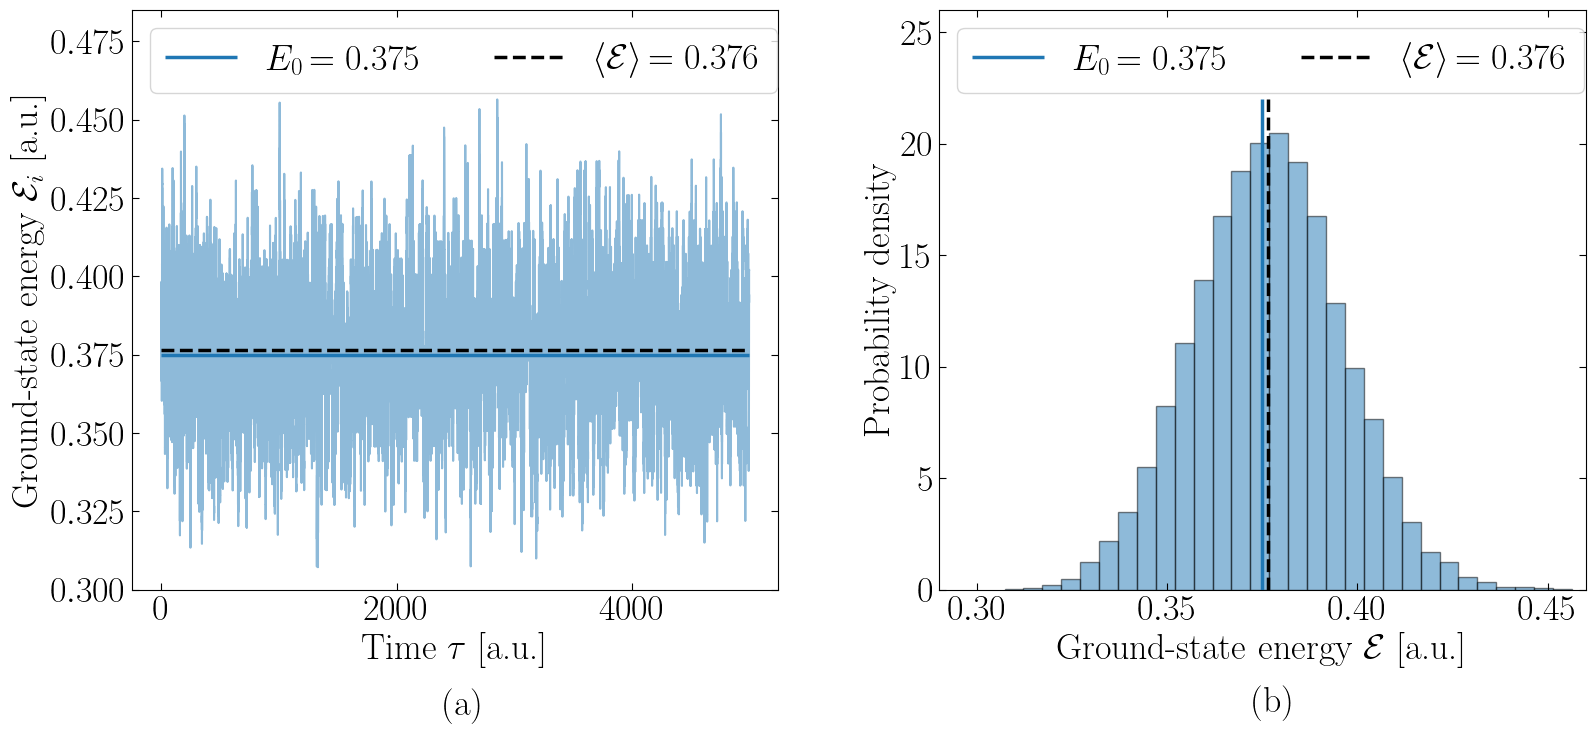

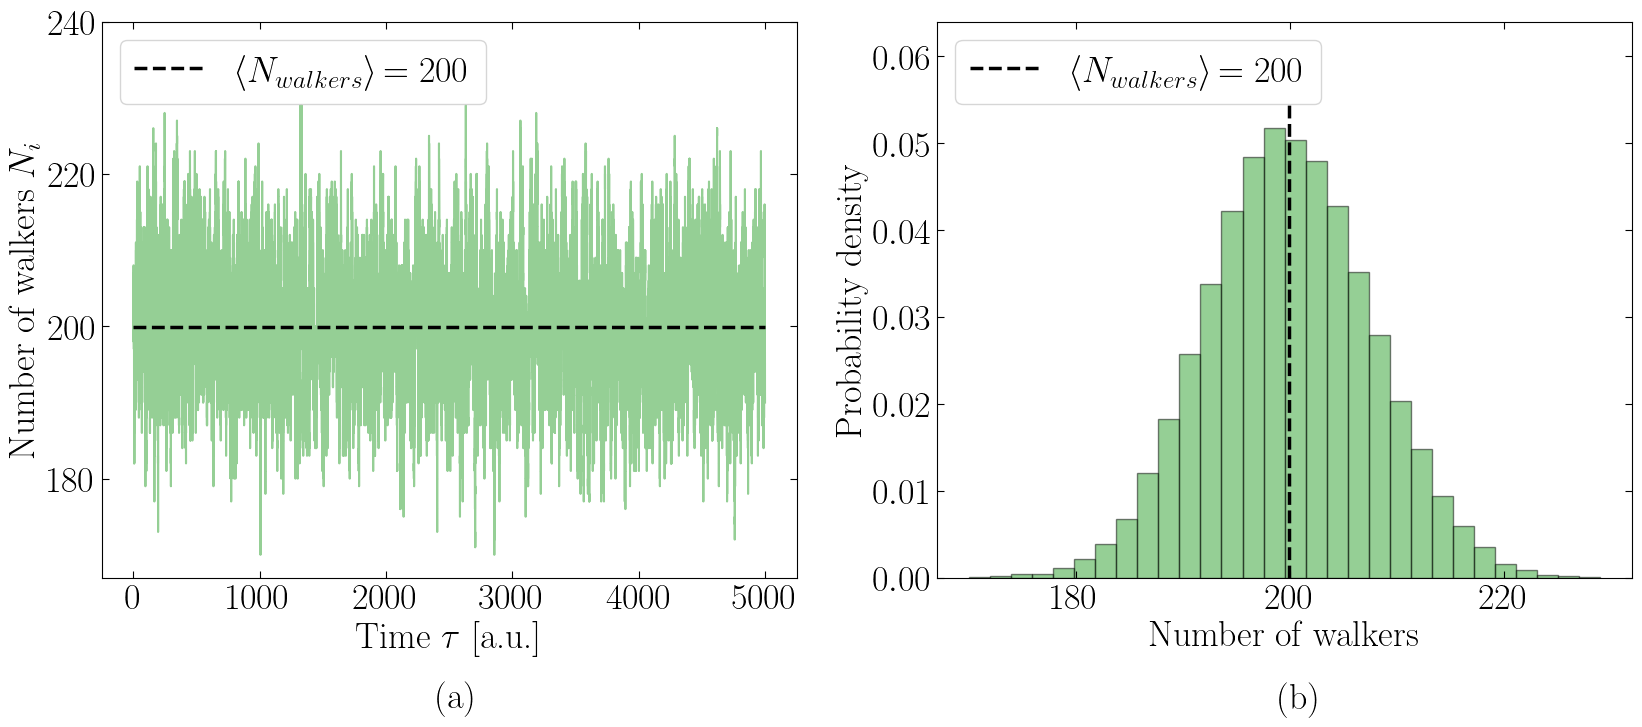

In [177]:

ET_avg, walk, mort_rate, ET = read_data('data/task_1/1D/ET_Nwalk_non_eq.csv')[:, :].T
tau = np.linspace(0, len(ET) * 0.02, len(ET))

fig,ax = plt.subplots(1,2,figsize=(17,8))


ax[0].plot(tau,ET,color='tab:blue',alpha = 0.5)
ax[0].hlines(3/8,0,len(ET) * 0.02,color='tab:blue', label="$E_0$"+f"$\\,={3/8:.3f}$",lw=2.5)
ax[0].hlines(np.mean(ET), 0, len(ET) * 0.02,colors='k', label='$\\langle \\mathcal{E}\\rangle$'+f'$\\, = {np.mean(ET):.3f}$',lw=2.5,ls = 'dashed')
ax[0].legend()
ax[0].set_xlabel('Time $\\tau$ [a.u.]')
ax[0].set_ylabel('Ground-state energy $\\mathcal{E}_i$ [a.u.]')
ax[0].set_ylim(0.3,0.485)
ax[0].legend(loc='upper left',ncol = 2) 

ax[1].hist(ET,bins=30,density=True,color='tab:blue',alpha=0.5,edgecolor='k')
ax[1].vlines(3/8,0,22,color='tab:blue', label="$E_0$"+f"$\\,={3/8:.3f}$",lw=2.5)
ax[1].vlines(np.mean(ET), 0, 22,colors='k', label='$\\langle \\mathcal{E}\\rangle$'+f'$\\, = {np.mean(ET):.3f}$',lw=2.5,ls = 'dashed')
ax[1].set_xlabel('Ground-state energy $\\mathcal{E}$ [a.u.]')
ax[1].set_ylabel('Probability density')
ax[1].set_ylim(0,26)
ax[1].legend(loc='upper left',ncol = 2)
ax[1].set_xlim(0.29,0.46)
ax[0].text(2400,0.26,'(a)')
ax[1].text(0.3725,-5.5,'(b)')
plt.tight_layout()
save_fig(plt, 'E_T', 1)



#plt.figure(figsize=(9, 6))
fig,ax = plt.subplots(1,2,figsize=(17,8))
# walk = read_data('ET_Nwalk_non_eq.csv')[:,1]
ax[0].plot(tau,walk,color='tab:green',alpha = 0.5)#, label='$N_i$')
#plt.hlines(200,0,np.max(tau),'b', linestyle = 'dashed')
ax[0].hlines(np.mean(walk),0,np.max(tau),colors ='k', label='$\\langle N_{walkers}\\rangle$'+f'$\\,= {np.mean(walk):.0f}$',linestyle='dashed',lw=2.5)
ax[0].set_xlabel('Time $\\tau$ [a.u.]')
ax[0].set_ylabel('Number of walkers $N_i$')
ax[0].set_ylim(167,240)
ax[0].legend(loc='upper left')
ax[1].hist(walk,bins=30,density=True,color='tab:green',alpha=0.5,edgecolor='k')
ax[1].set_xlabel('Number of walkers')
ax[1].set_ylabel('Probability density')
ax[1].vlines(np.mean(walk),0,0.055,colors='k',linestyle='dashed',label='$\\langle N_{walkers}\\rangle$'+f'$\\,= {np.mean(walk):.0f}$',lw=2.5)
ax[1].set_ylim(0,0.064)
ax[1].legend(loc='upper left')
ax[0].text(2400,150,'(a)')
ax[1].text(199,-0.015,'(b)')
plt.tight_layout()
save_fig(plt, 'N_walkers', 1)

# plt.figure()
# #mortality_rate = read_data('ET_Nwalk_non_eq.csv')[:,2]
# plt.plot(tau, mort_rate)
# plt.hlines(100,0,np.max(tau),'b', linestyle = 'dashed')
# plt.hlines(np.mean(mort_rate), 0, np.max(tau),colors='k', label='Mortality rate'+f' = {np.mean(mort_rate):.1f}\\%')
# plt.legend()

plt.show()


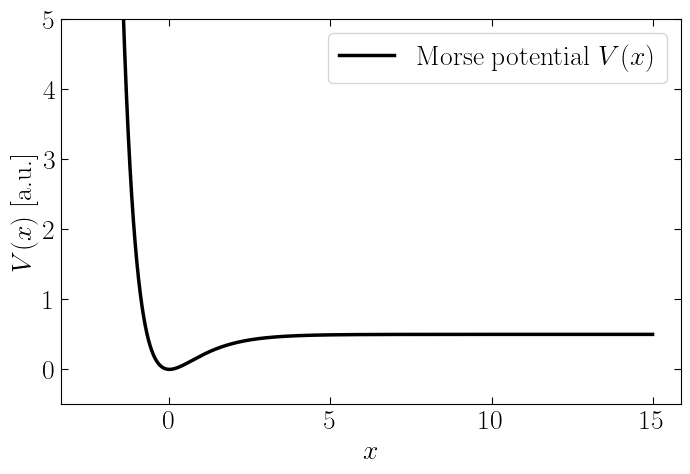

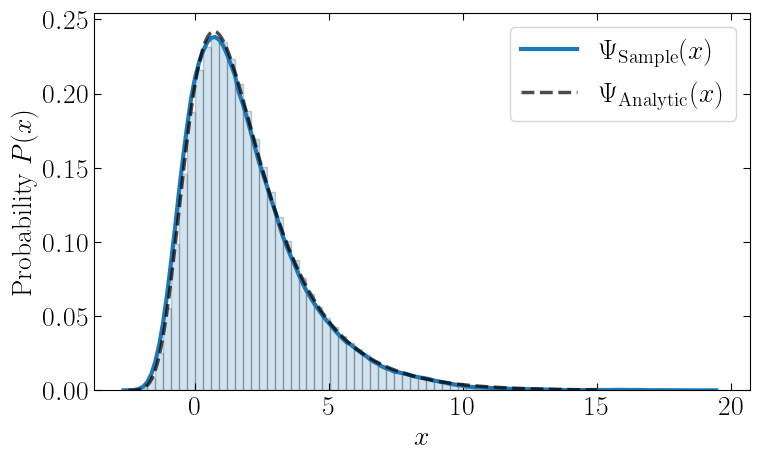

In [84]:
x = np.linspace(-2.5, 15, 10000)
psi = np.exp(-np.exp(-x) - x/2) / np.sqrt(np.pi)
Morse = 0.5 * (1 - np.exp(-x)) ** 2

plt.figure(figsize=(8, 5))
plt.plot(x, Morse, label='Morse potential $V(x)$', color='k', lw=2.5)
plt.xlabel('$x$')
plt.ylabel('$V(x)$ [a.u.]')
plt.ylim(-.5, 5)
plt.legend()

bin_size = 150
plt.figure(figsize=(8, 5))
walker_pos = read_data('data/task_1/1D/I_was_walkin_in_morse.csv')
walker_pos = walker_pos[~np.isnan(walker_pos)]

counts, bins = np.histogram(walker_pos, bins=bin_size)

# Normalize manually
bin_width = bins[1] - bins[0]  # Width of each bin
normalized_counts = counts / (np.sum(counts) * bin_width)

# Plot the manually normalized histogram
plt.hist(walker_pos, bins=int(bin_size/2), density=True, color='tab:blue', alpha=0.2, edgecolor='black', lw=1)
plt.plot(bins[:-1], normalized_counts, color='tab:blue', lw=3, label='$\\Psi_\\mathrm{Sample}(x)$')
plt.plot(x, psi, label='$\\Psi_\\mathrm{Analytic}(x)$', color = 'k', lw=2.5, ls = 'dashed',alpha = 0.7)
plt.xlabel('$x$')
plt.ylabel('Probability $P(x)$')


plt.legend()
plt.tight_layout()
save_fig(plt, 'Wavefunc', 1)
plt.show()
